In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
# Set a random seed for reproducibility
np.random.seed(0)
 
# Load your temperature dataset with columns "DATE" and "Temperature"
data = pd.read_csv('JaipurFinalCleanData.csv')
 
# Make sure your "Date" column is in datetime format
data['date'] = pd.to_datetime(data['date'])
 
# Resetting the index
data.set_index('date', inplace=True)
 
data.dropna(inplace=True)

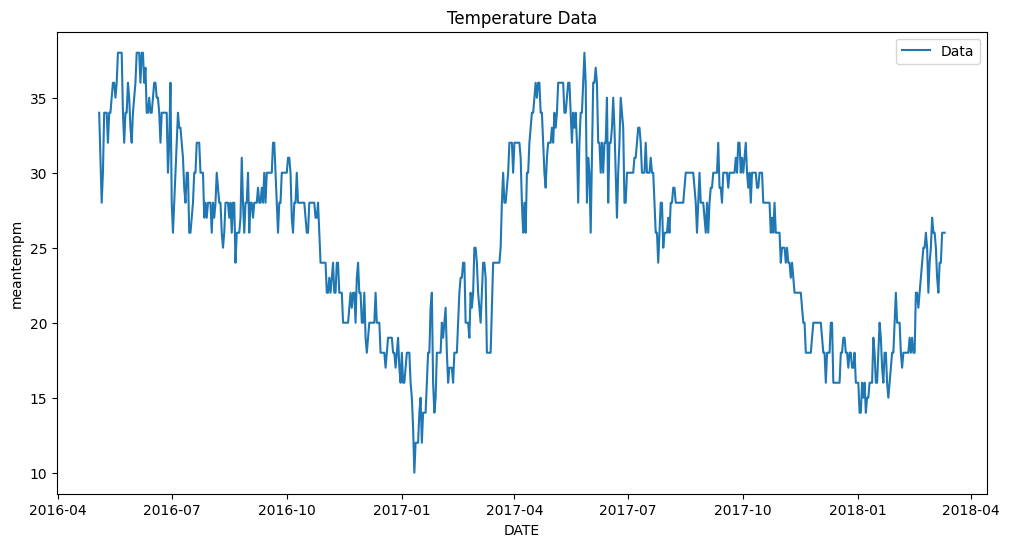

In [2]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot( data['meantempm'], label='Data')
plt.xlabel('DATE')
plt.ylabel('meantempm')
plt.legend()
plt.title('Temperature Data')
plt.show()

In [3]:
data.describe

<bound method NDFrame.describe of             meantempm  maxtempm  mintempm  meantempm_1  meantempm_2  \
date                                                                  
2016-05-04         34        41        27         35.0         36.0   
2016-05-05         31        38        24         34.0         35.0   
2016-05-06         28        34        21         31.0         34.0   
2016-05-07         30        38        23         28.0         31.0   
2016-05-08         34        41        26         30.0         28.0   
...               ...       ...       ...          ...          ...   
2018-03-07         24        32        15         22.0         23.0   
2018-03-08         24        32        15         24.0         22.0   
2018-03-09         26        33        19         24.0         24.0   
2018-03-10         26        34        19         26.0         24.0   
2018-03-11         26        34        18         26.0         26.0   

            meantempm_3  meandewptm_1  mea

In [4]:
# Adding lag features to the DataFrame
for i in range(1, 6):  # Creating lag features up to 5 days
    data[f'Lag_{i}'] = data['meantempm'].shift(i)
 
# Drop rows with NaN values resulting from creating lag features
data.dropna(inplace=True)

# Split the data into training and testing sets
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Reset index for both train and test data
train_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

 
# Define the input features (lag features) and target variable
 
y_train = train_data['meantempm']
 
y_test = test_data['meantempm']

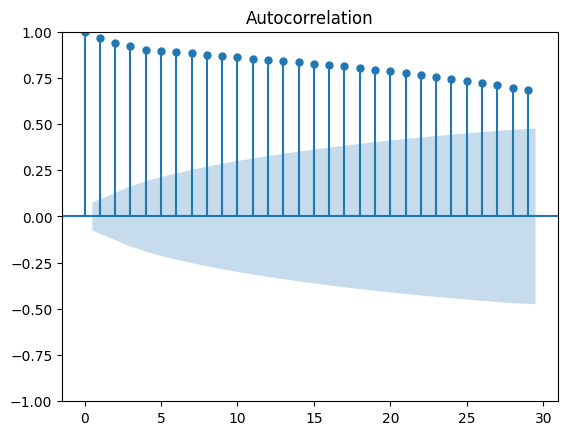

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
series = data['meantempm']
plot_acf(series)
plt.show()

In [6]:
data['meantempm'].corr(data['meantempm'].shift(1))


0.9674296014985275

In [7]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create and train the autoregressive model
lag_order = 235 # Adjust this based on the ACF plot
ar_model = AutoReg(y_train, lags=lag_order)
ar_results = ar_model.fit()


In [8]:
# Make predictions on the test set
y_pred = ar_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)
#print(y_pred)

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')


Mean Absolute Error: 3.93
Root Mean Squared Error: 4.84


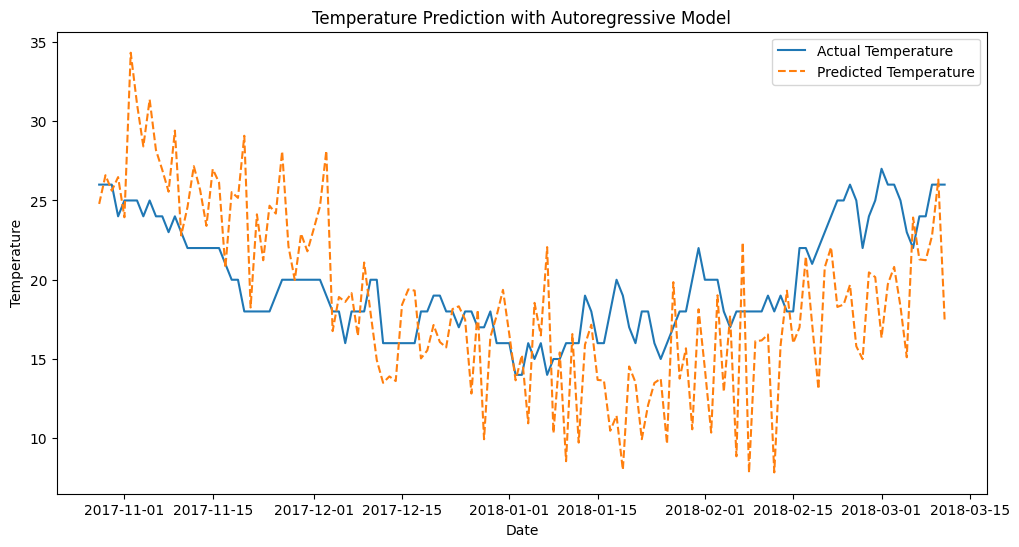

In [9]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(test_data["date"] ,y_test, label='Actual Temperature')
plt.plot( test_data["date"],y_pred, label='Predicted Temperature', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.title('Temperature Prediction with Autoregressive Model')
plt.show()


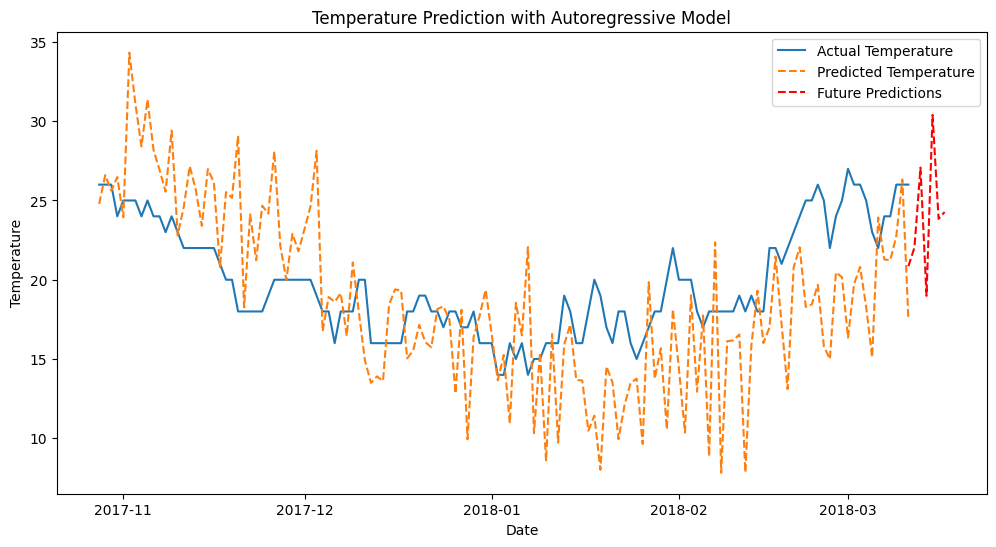

In [10]:
# Define the number of future time steps you want to predict (1 week)
forecast_steps = 7

# Extend the predictions into the future for one year
future_indices = range(len(test_data), len(test_data) + forecast_steps)
future_predictions = ar_results.predict(start=len(train_data), end=len(train_data) + len(test_data) + forecast_steps - 1, dynamic=False)

# Create date indices for the future predictions
future_dates = pd.date_range(start=test_data['date'].iloc[-1], periods=forecast_steps, freq='D')

# Plot the actual data, existing predictions, and one year of future predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data['date'], y_test, label='Actual Temperature')
plt.plot(test_data['date'], y_pred, label='Predicted Temperature', linestyle='--')
plt.plot(future_dates, future_predictions[-forecast_steps:], label='Future Predictions', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.title('Temperature Prediction with Autoregressive Model')
plt.show()
